# LSTM - Nasdaq-100 data

**Notebook Summary**


**Granularity**: minute data

**Source**: Refinitiv

**Time period**: 03-01-2023 / 05-15-2023

**Model**: LSTM

#Importing libraries

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import io
import math
import pandas as pd
import numpy as np
import datetime
from datetime import time

# Keras
import keras
from keras.layers import *
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

# Sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving nasdaq100-ultimo.xlsx to nasdaq100-ultimo.xlsx


# Load data


In [4]:
# Import raw data
data = pd.read_excel(io.BytesIO(uploaded['nasdaq100-ultimo.xlsx']))

# Exploratory analysis

In [5]:
data.head()

,Local Date,Local Time,Close,Net,%Chg,Open,Low,High,Volume
0,2023-05-15 21:00:00,2023-05-15 21:00:00,13414.978,7.340,0.000547,13408.672,13406.831,13414.978,5872939
1,2023-05-15 20:59:00,2023-05-15 20:59:00,13407.638,-0.568,-0.000042,13408.515,13406.908,13408.515,2578428
2,2023-05-15 20:58:00,2023-05-15 20:58:00,13408.206,3.740,0.000279,13404.600,13403.706,13408.901,1856072
3,2023-05-15 20:57:00,2023-05-15 20:57:00,13404.466,2.494,0.000186,13401.677,13401.473,13405.016,1457454
4,2023-05-15 20:56:00,2023-05-15 20:56:00,13401.972,-5.011,-0.000374,13404.145,13400.701,13404.145,1705538


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32641 entries, 0 to 32640
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Local Date  32641 non-null  datetime64[ns]
 1   Local Time  32641 non-null  datetime64[ns]
 2   Close       32641 non-null  float64       
 3   Net         32640 non-null  float64       
 4   %Chg        32640 non-null  float64       
 5   Open        32641 non-null  float64       
 6   Low         32641 non-null  float64       
 7   High        32641 non-null  float64       
 8   Volume      32641 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 2.2 MB


In [7]:
# Set a time index
data.set_index('Local Time', inplace = True)
data = data[['Close']]
data.sort_index(inplace = True)

In [8]:
data

,Close
Local Time,
2023-03-01 14:31:00,12022.784
2023-03-01 14:32:00,12035.656
2023-03-01 14:33:00,12023.583
2023-03-01 14:34:00,12009.438
2023-03-01 14:35:00,12003.977
...,...
2023-05-15 20:56:00,13401.972
2023-05-15 20:57:00,13404.466
2023-05-15 20:58:00,13408.206


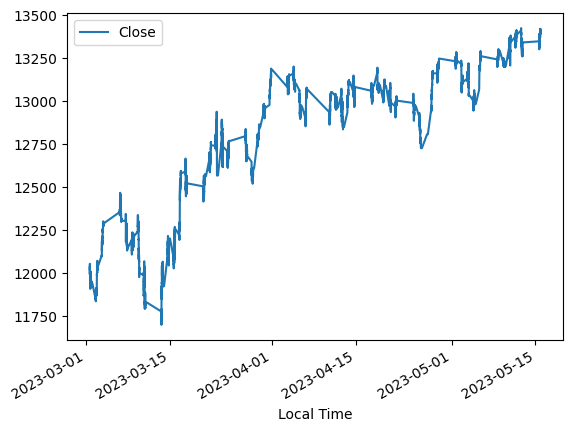

In [9]:
# Plot the closing price
data.plot()
plt.show()

In [10]:
# Create a new feature
log_returns = np.log(data["Close"]).diff(1) 
data["log_returns"] = log_returns 

In [11]:
# Refine the dataset
data = data[["log_returns"]]

In [12]:
# Drop the first NaN observation
data = data.dropna()

# In order to get more accurate predictions and reduce oscillations, we remove the first and last hour of trading within each day 
data = data.loc[(data.index.time > time(15,30)) & (data.index.time < time(20,00))]
data = data[['log_returns']]
data

,log_returns
Local Time,
2023-03-01 15:31:00,-0.000619
2023-03-01 15:32:00,-0.000411
2023-03-01 15:33:00,-0.000395
2023-03-01 15:34:00,0.000823
2023-03-01 15:35:00,0.000372
...,...
2023-05-15 19:55:00,-0.000153
2023-05-15 19:56:00,0.000114
2023-05-15 19:57:00,-0.000035


#Data processing

### Train-Test split

In [13]:
# Train and test split
ratio = 0.8
train_size = int(len(data)* ratio) 
train_data = data[:train_size]
test_data = data[train_size:]

In [14]:
train_data

,log_returns
Local Time,
2023-03-01 15:31:00,-0.000619
2023-03-01 15:32:00,-0.000411
2023-03-01 15:33:00,-0.000395
2023-03-01 15:34:00,0.000823
2023-03-01 15:35:00,0.000372
...,...
2023-05-01 18:07:00,-0.000017
2023-05-01 18:08:00,0.000147
2023-05-01 18:09:00,0.000116


### Building input features

In [15]:
# Define the look-back and look-forward variables
look_back = 50
look_forward = 10

In [16]:
# Convert an array of values into a dataset matrix

def create_features(data, look_back=50, look_forward=10):
    dataX, dataY = [], []
    np.array(dataY)
    for k in range(len(data)-look_back-1):
        a = data[k:(k + look_back), 0]
        if len(data[k + look_back: k + look_back + look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(data[k + look_back: k + look_back + look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
# Generate train X and train Y data
trainX, trainY = create_features(train_data.values, look_back, look_forward)

In [18]:
# Generate test X and test Y data
testX, testY = create_features(test_data.values, look_back, look_forward)

###Reshape to 3D data

In [19]:
# Reshape input to be (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
# Print out the shape of train and test X/Y
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(11131, 50, 1)
(11131, 10)
(2739, 50, 1)
(2739, 10)


#LSTM Model Builder

In [21]:
# Create a function that build an LSTM 

def create_lstm(input_shape = (look_back, 1), lstm_units=128, dense_units=10, drop_rate = 0.1):
    # Initialising the LSTM
    model = Sequential()

    # Adding the LSTM layer and some dropout regularization
    model.add(LSTM(units=lstm_units, input_shape=input_shape, stateful=False))
    model.add(Dropout(rate = drop_rate))

    # Adding a Dense layer
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= lstm_units))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(units= dense_units))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
    return model


In [22]:
# Instantiate an LSTM model to wrap in KerasRegressor
lstm = KerasRegressor(build_fn = create_lstm, verbose=0)

# Block Time Series Split and GridSearch CV

In [23]:
# Define a Block Time Series Split (no overlapping data)
class BlockTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            end = start + k_fold_size
            mid = int(0.5 * (end - start)) + start
            yield indices[start: mid], indices[mid + margin: end]

In [24]:
# Define the number of splits and get some metrics
btscv = BlockTimeSeriesSplit(n_splits= 6)

###Define the parameters to tune

In [25]:
# Define the parameter grid for GridSearch
param_grid = {
    'batch_size': [64, 128],
    'epochs': [15, 20],
    'drop_rate' : [0.1, 0.15],
    'lstm_units':[128, 256]}

###Run GridSearchCV

In [26]:
# Create the GridSearchCV object with BlockTimeSeriesSplit
grid_search = GridSearchCV(estimator = lstm, param_grid = param_grid, cv = btscv, scoring = 'neg_mean_squared_error')

In [27]:
# Fit the data to the GridSearchCV object
grid_result = grid_search.fit(trainX, trainY)

In [28]:
# Print the best parameters and best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_
print("Best parameters:", best_params)
print("Best score:" , best_score)

Best parameters: {'batch_size': 128, 'drop_rate': 0.1, 'epochs': 20, 'lstm_units': 128}
Best score: -1.9056112289305482e-07


# Fit the best model

In [29]:
# Store the best_params dictionary to avoid re-running GridSearch
#best_params = {'batch_size': 128, 'drop_rate': 0.1, 'epochs': 20, 'lstm_units': 128}

In [30]:
# Use the best parameters to create the LSTM model
model = create_lstm(lstm_units =best_params['lstm_units'], drop_rate = best_params['drop_rate'])

In [31]:
# Fitting the model
history = model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/20
87/87 [==============================] - 12s 115ms/step - loss: 2.6744e-06 - accuracy: 0.1026
Epoch 2/20
87/87 [==============================] - 9s 102ms/step - loss: 2.2234e-07 - accuracy: 0.1075
Epoch 3/20
87/87 [==============================] - 10s 112ms/step - loss: 2.4194e-07 - accuracy: 0.0981
Epoch 4/20
87/87 [==============================] - 10s 111ms/step - loss: 2.6709e-07 - accuracy: 0.0974
Epoch 5/20
87/87 [==============================] - 10s 114ms/step - loss: 2.9947e-07 - accuracy: 0.0994
Epoch 6/20
87/87 [==============================] - 8s 92ms/step - loss: 2.9066e-07 - accuracy: 0.1027
Epoch 7/20
87/87 [==============================] - 10s 110ms/step - loss: 2.7782e-07 - accuracy: 0.1007
Epoch 8/20
87/87 [==============================] - 10s 114ms/step - loss: 2.9531e-07 - accuracy: 0.0986
Epoch 9/20
87/87 [==============================] - 10s 115ms/step - loss: 3.1980e-07 - accuracy: 0.0966
Epoch 10/20
87/87 [==============================] - 9s 10

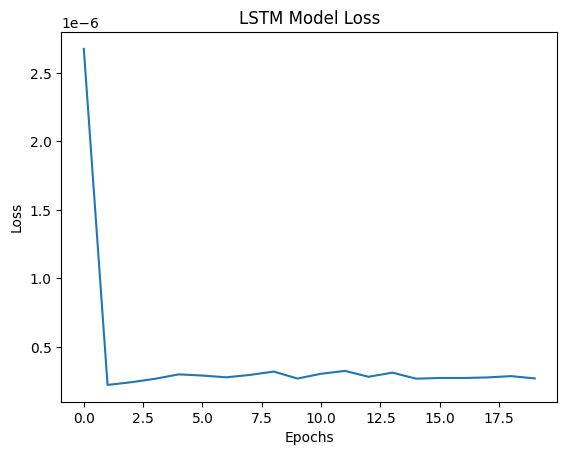

In [32]:
# Plot the loss over the epochs
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [33]:
# Predict the model using test X data
y_pred = model.predict(testX)

86/86 [==============================] - 2s 20ms/step


In [34]:
# Get a sense of how y_pred looks like
y_pred

array([[-0.00041393,  0.00019408, -0.00016913, ...,  0.00040941,
        -0.00024062, -0.00020926],
       [-0.00041761,  0.00019393, -0.00016802, ...,  0.00041326,
        -0.00023915, -0.00020697],
       [-0.0004184 ,  0.00019404, -0.0001679 , ...,  0.0004143 ,
        -0.00023875, -0.00020656],
       ...,
       [-0.0004238 ,  0.0001943 , -0.00016688, ...,  0.00042129,
        -0.00023566, -0.00020365],
       [-0.00041709,  0.00019455, -0.00016895, ...,  0.00041454,
        -0.000238  , -0.00020776],
       [-0.00041655,  0.0001943 , -0.00016895, ...,  0.0004138 ,
        -0.00023813, -0.00020792]], dtype=float32)

In [35]:
print(y_pred.shape)

(2739, 10)


###Compute the MSE and RMSE

In [36]:
mse = mean_squared_error(testY, y_pred)
rmse = math.sqrt(mse)
print("MSE:",mse)
print("RMSE:", rmse)

MSE: 2.188377418505261e-07
RMSE: 0.00046780096392646104


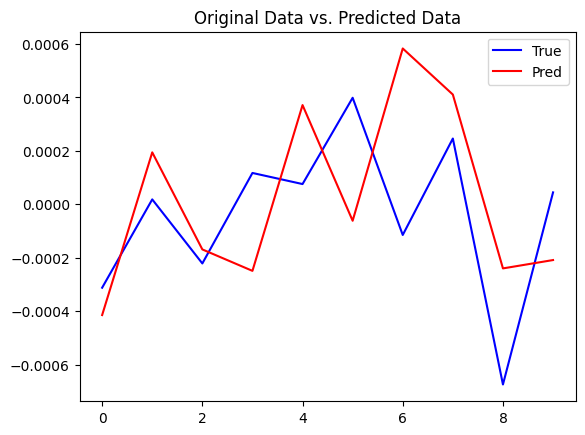

In [37]:
# Plot one prediction against test data
plt.plot(testY[3], color = "b", label = "True")
plt.plot(y_pred[3], color = "r", label = "Pred")
plt.title('Original Data vs. Predicted Data')
plt.legend()
plt.show()

# Get a single prediction

In [38]:
# Extract a single observation
single = testX[20].reshape(1, testX[20].shape[0], testX[20].shape[1])
single.shape

(1, 50, 1)

In [39]:
# Make a prediction
single_pred = model.predict(single)

1/1 [==============================] - 0s 24ms/step


In [40]:
single_pred

array([[-4.1657273e-04,  1.9364679e-04, -1.6786568e-04, -2.4803320e-04,
         3.6795979e-04, -5.9837170e-05,  5.8084668e-04,  4.1079841e-04,
        -2.4065269e-04, -2.0720743e-04]], dtype=float32)

In [41]:
single_pred.shape

(1, 10)

In [42]:
# Get the corresponding test array
single_test = testY[20].reshape(1, testY.shape[1])
single_test.shape

(1, 10)

###Compute the MSE

In [43]:
mse = mean_squared_error(single_test, single_pred)
print("MSE:", mse)

MSE: 1.2532515355894787e-07


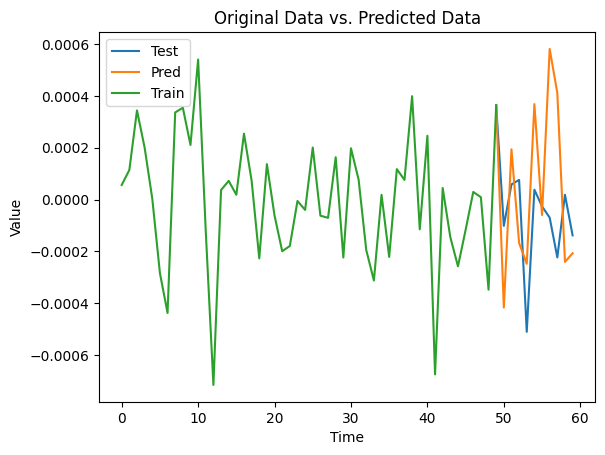

In [44]:
# Plot
plt.plot(list(range(49,60)), np.insert(single_test.reshape(10,), 0, single[0,49,0]), label='Test')
plt.plot(list(range(49,60)), np.insert(single_pred.reshape(10,), 0, single[0,49,0]), label='Pred')
plt.plot(list(range(0,50)), single.reshape(50,), label='Train')


# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data vs. Predicted Data')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Plot the predictions

In [45]:
# Indexing data 
times_exploded = []
forecast_len = testY.shape[1]
idx_list = data.index.to_list()

for i in range(len(data.index) - forecast_len):
  times_exploded.append(pd.to_datetime(idx_list[i : i + forecast_len]))

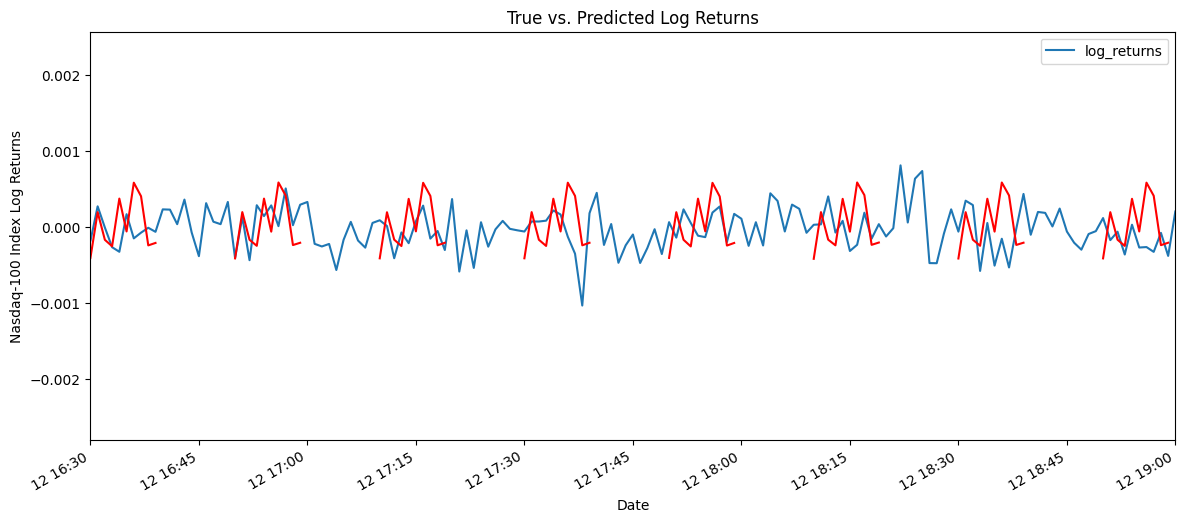

In [54]:
# Plot the log returns

# Define dates
start_time = pd.to_datetime("2023-05-12 16:30")
end_time = pd.to_datetime("2023-05-12 19:00")

# Adjust x-axis limits
ax = (data.iloc[-len(y_pred):]).plot(
    style="-",
    title="True vs. Predicted Log Returns",
    xlabel="Date",
    ylabel="Nasdaq-100 Index Log Returns",
    xlim=[start_time, end_time],
    figsize=(14, 6))

times = times_exploded[-len(y_pred):]
for idx in range(10, len(y_pred), 20):
  plt.plot(times[idx], y_pred[idx], color = 'r')

# Add legend 
ax.legend()